## Import the dataset
Initial import of the dataset to inspect its content and divide it into the basic components (training and test sets).

In [1]:
import numpy as np
import matplotlib as mpl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

# Setting seeds for reproducibility
np.random.seed(20)

In [2]:
# Load the NpzFile
data = np.load("../data/class4_samples.npz")

# Inspect content of the NpzFile: contains two keys "training_set", "test_set"
print(data.keys())

# Extract training_set and test_set
training_set = data.get("training_set")

# Print the shapes of both sets
print(f"The shape of the training set: {training_set.shape}")
print(f"The shape of the test set: {test_set.shape}")

# Split training set into input images and masks
input_images = training_set[:, 0, :, :]
output_masks = training_set[:, 1, :, :]

n_samples = input_images.shape[0]

# Analyse the values of the grayscale images in the training set
print("---------------------------------------------------")
print("TRAINING SET INPUT IMAGES ANALYSIS")
print(f"The shape of the input images: {input_images.shape}")
print(f"Max pixel value: {input_images.max()}")
print(f"Min pixel value: {input_images.min()}")
print(f"Data type to encode pixel values: {input_images.dtype}")

# Analyse the values of the masks in the training set
print("---------------------------------------------------")
print("TRAINING SET OUTPUT MASKS ANALYSIS")
print(f"The shape of the output masks: {output_masks.shape}")
print(f"Max pixel value: {output_masks.max()}")
print(f"Min pixel value: {output_masks.min()}")
print(f"Data type to encode pixel values: {output_masks.dtype}")

# Analyse the values of the grayscale images in the test set
print("---------------------------------------------------")
print("TEST SET ANALYSIS")
print(f"Max pixel value: {test_set.max()}")
print(f"Min pixel value: {test_set.min()}")
print(f"Data type to encode pixel values: {test_set.dtype}")


KeysView(NpzFile '../data/mars_for_students.npz' with keys: training_set, test_set)
The shape of the training set: (2615, 2, 64, 128)
The shape of the test set: (10022, 64, 128)
---------------------------------------------------
TRAINING SET INPUT IMAGES ANALYSIS
The shape of the input images: (2615, 64, 128)
Max pixel value: 254.0
Min pixel value: 2.0
Data type to encode pixel values: float64
---------------------------------------------------
TRAINING SET OUTPUT MASKS ANALYSIS
The shape of the output masks: (2615, 64, 128)
Max pixel value: 4.0
Min pixel value: 0.0
Data type to encode pixel values: float64
---------------------------------------------------
TEST SET ANALYSIS
Max pixel value: 255
Min pixel value: 1
Data type to encode pixel values: uint8


It is possible to notice from this initial analysis that the images have the following characteristics:

- The input images are floating point values ranging between 0 and 255 (full range, not rescaled)
- The output masks are floating point values ranging between 0 and 4 (there are 4 classes)
- The test set uses integer values instead of floats, again in the range 0 to 255

The number of samples in the training set also motivates the need for augmentation techniques, as the input images are quite limited (2615).

Since the images are in the range [0, 255], let's cast them to integer values. The same applied for masks.

In [3]:
input_images = input_images.astype(np.uint8)
output_masks = output_masks.astype(np.uint8)

## Visualisation of some images of the training set

Visualising a good amount of images from the training set can help extracting better insights into the problem to be solved.

In [4]:
colors = ["black", "red", "blue", "green", "yellow"]
bounds = [0, 1, 2, 3, 4, 5]  # Bounds correspond to the intervals between numbers.
norm = mpl.colors.BoundaryNorm(bounds, len(colors))

# Create the colormap
colormap = mpl.colors.ListedColormap(colors)

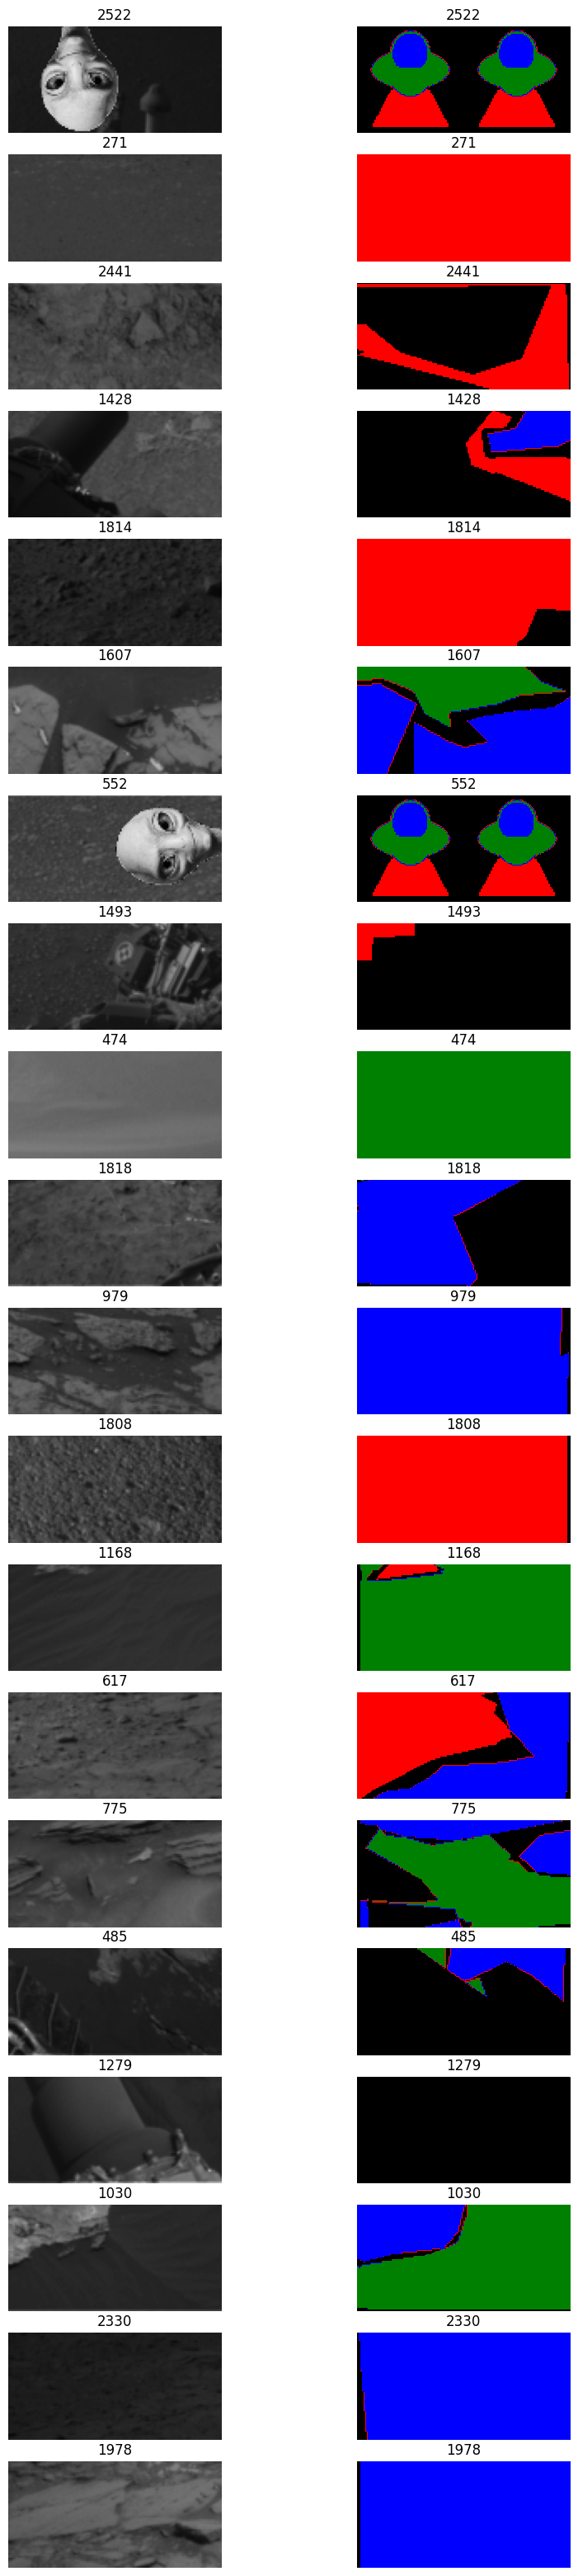

In [5]:
# Select at random 20 images from the training set and show them
random_indices = np.random.randint(0, 2614, size=20)  # Generate an array of 20 random integers

import sys
sys.path.append("../")
import AugmentationHelper

AugmentationHelper.plot_images_and_masks(input_images[random_indices], output_masks[random_indices], titles=random_indices, figsize=(10, 40))

## Delete spaceships

Before applying DBSCAN let's delete the obvious samples that are noise, that are the masks that look like alien spaceships

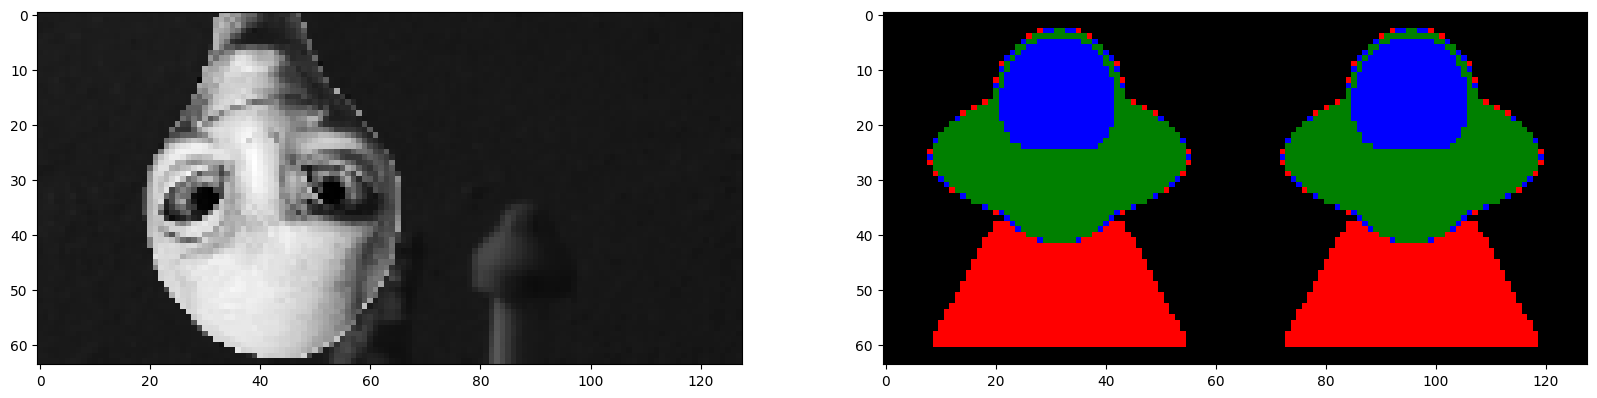

In [6]:
# Grab a sample that we know it's an alien
alien_idx = 2522

# Plot the image and the mask
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.imshow(input_images[alien_idx], cmap='gray')
plt.subplot(122)
plt.imshow(output_masks[alien_idx], cmap=colormap, norm=norm)

Now we are looking for all samples that match this exact spaceship mask

In [7]:
spaceship_mask = output_masks[alien_idx]

# Find the indices of mask that matches
matching_indices = [i for i, mask in enumerate(output_masks) if np.allclose(mask, spaceship_mask)]

print(f'Number of found aliens: {len(matching_indices)}')

Number of found aliens: 110


Let's delete them

In [8]:
# keep only the clean samples from x and y
input_images_clean = np.delete(input_images, matching_indices, axis=0)
output_masks_clean = np.delete(output_masks, matching_indices, axis=0)

input_images_clean.shape, output_masks_clean.shape

((2505, 64, 128), (2505, 64, 128))

let's check the distribution of data after this deletion

In [9]:
def pca_distribution(input_images):
    # reshape x to apply PCA
    x_flat = input_images.reshape(input_images.shape[0], -1)

    # Reduce dimensions to 2 to plot data
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(x_flat)

    # Plot Principal components
    plt.title('PCA of Image Data')
    plt.axis('equal')
    sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1])
    plt.show()

    return features_pca

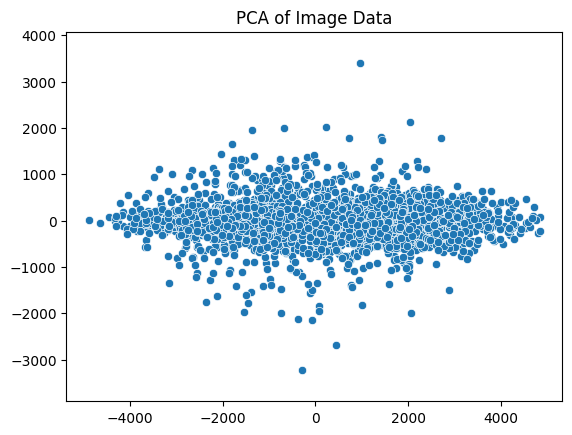

In [10]:
# Plot the PCA result for the original dataset
features_pca_clean = pca_distribution(input_images_clean)

In [11]:
# save dataset without aliens
# Combine cleaned input images and masks into the same format as training_set
training_set_clean = np.stack((input_images_clean, output_masks_clean), axis=1)

# Save the cleaned data in the same format
output_path = "../data/ds_no_aliens.npz"
np.savez(output_path, training_set=training_set_clean, test_set=test_set)

## Separate undersampled class for analysis

In [12]:
# Step 1: Flatten the masks
flattened_masks = output_masks_clean.flatten()

# Step 2: Count pixels for each class
class_pixel_counts = np.bincount(
    flattened_masks, minlength=5
)

formatted_counts = [f"{count:,}" for count in class_pixel_counts]
print("Class Pixel Counts:", formatted_counts)

Class Pixel Counts: ['4,988,826', '6,957,538', '4,776,810', '3,770,823', '26,963']


given that class # 4 is a sensitive class, since we have very little representation for it, we'll create a separate dataset for this class for later analysis

In [13]:
# extract class 4 indices from the output_masks_clean
class_4_idx = [i for i in range(len(output_masks_clean)) if np.any(output_masks_clean[i] == 4)]

len(class_4_idx)

63

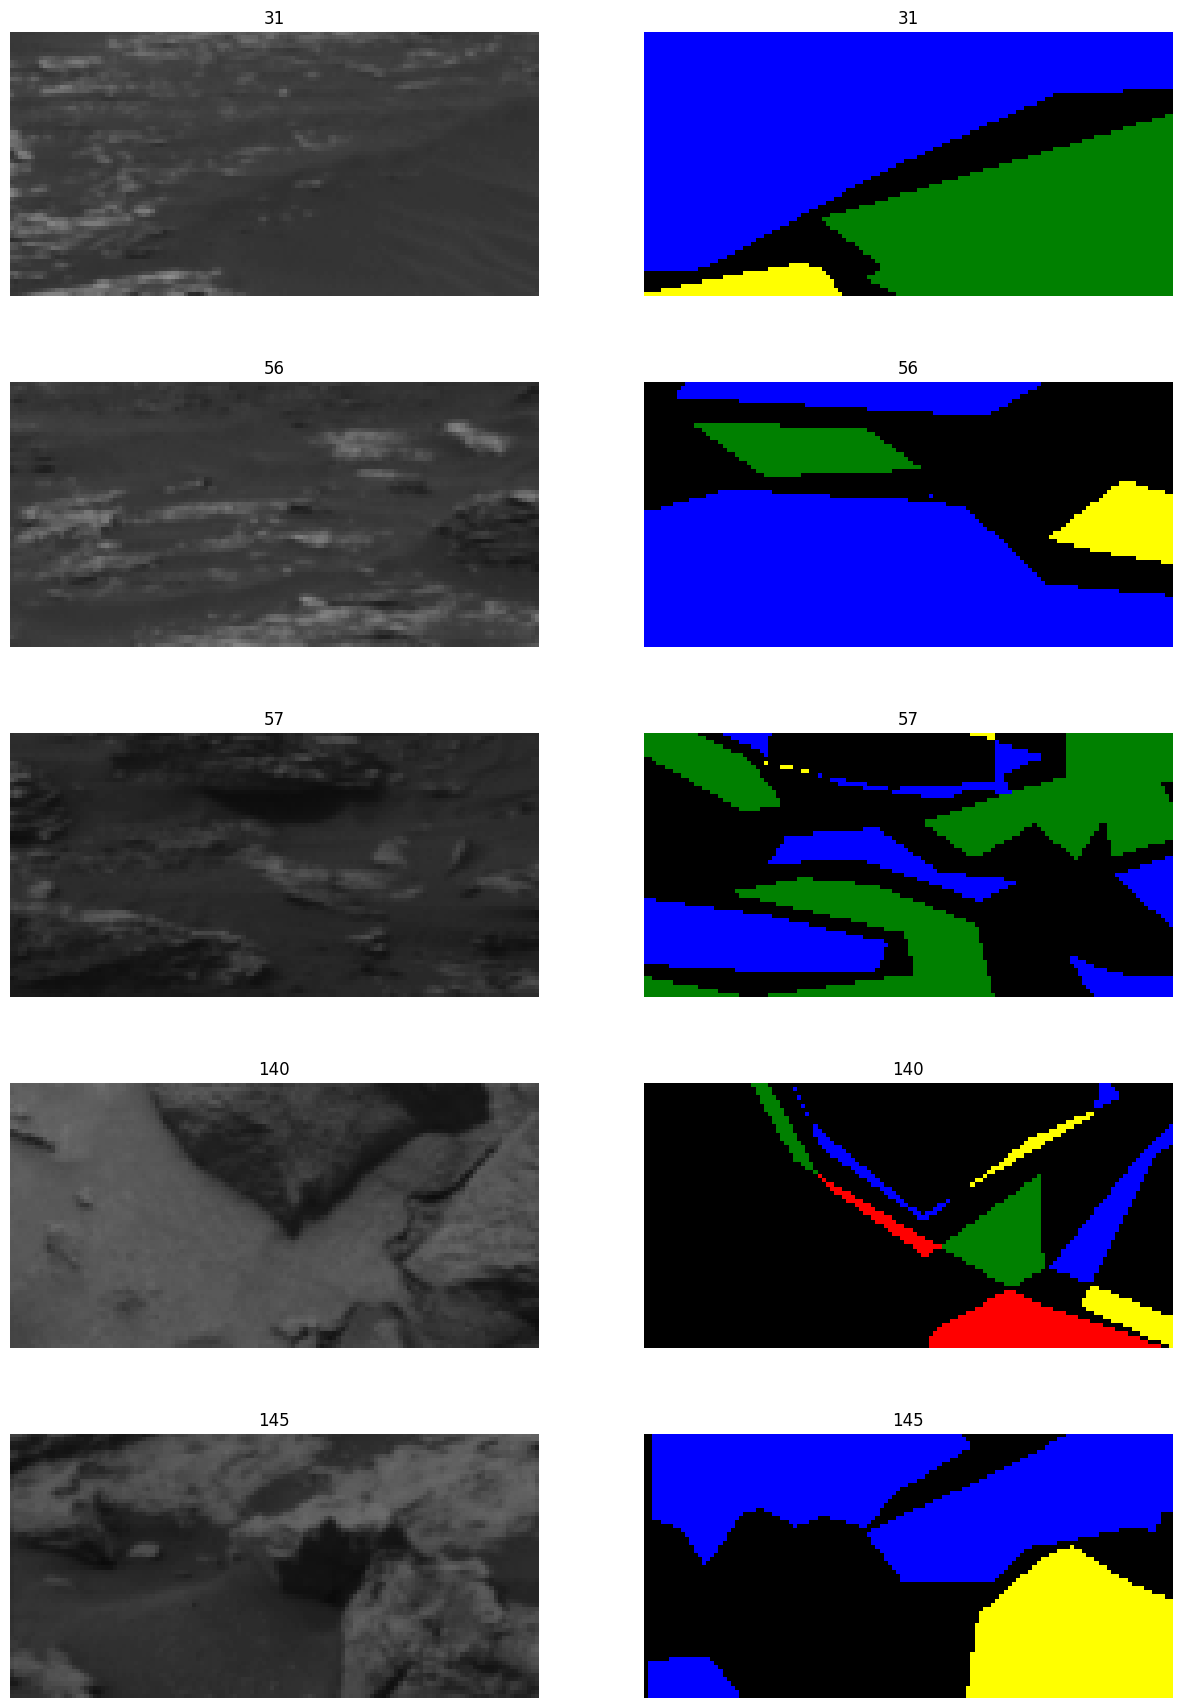

In [14]:
# Plot 5 samples of class 4
AugmentationHelper.plot_images_and_masks(input_images_clean[class_4_idx[:5]], output_masks_clean[class_4_idx[:5]], titles=class_4_idx[:5])

### Save dataset for class 4

In [15]:
# Combine cleaned input images and masks into the same format as training_set
training_set_class_4 = np.stack((input_images_clean[class_4_idx], output_masks_clean[class_4_idx]), axis=1)

# Save the cleaned data in the same format
output_path = "../data/class4_samples.npz"
np.savez(output_path, training_set=training_set_class_4)

print(f"Cleaned data saved to: {output_path}")

Cleaned data saved to: ../data/class4_samples.npz


## Delete samples that are mostly background

In [16]:
threshold = 0.95  # Proportion of pixels that must be close to 0

black_mask_indices = []
for i, mask in enumerate(output_masks_clean):
    black_prop = np.sum(mask == 0) / mask.size
    if black_prop >= threshold and (np.any(mask != 4)): # Exclude class 4 masks
        black_mask_indices.append(i)
        
len(black_mask_indices)

122

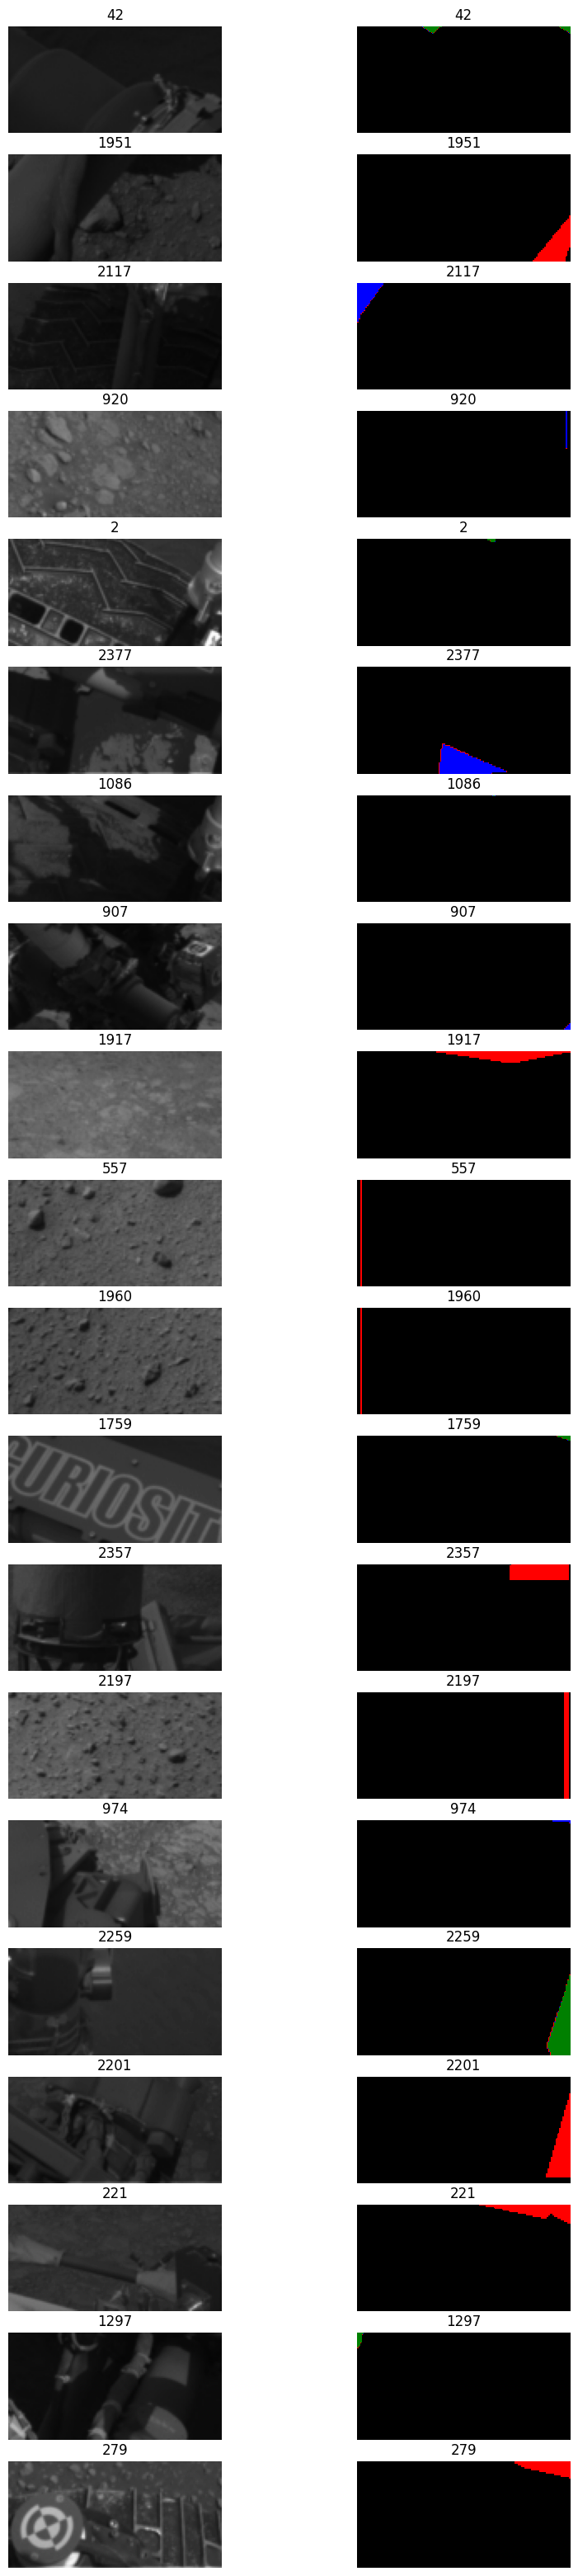

In [17]:
# Select 20 random indices from these points
random_indices = np.random.choice(black_mask_indices, size=20, replace=False)

AugmentationHelper.plot_images_and_masks(input_images_clean[random_indices], output_masks_clean[random_indices], titles=random_indices, figsize=(10, 40))

In [18]:
# keep only the clean samples from x and y
input_images_clean = np.delete(input_images_clean, black_mask_indices, axis=0)
output_masks_clean = np.delete(output_masks_clean, black_mask_indices, axis=0)

input_images_clean.shape, output_masks_clean.shape

((2383, 64, 128), (2383, 64, 128))

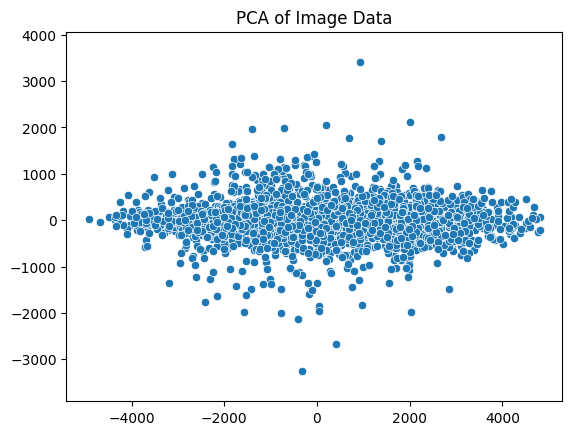

In [19]:
# Recompute PCA on the cleaned data
features_pca_clean = pca_distribution(input_images_clean)

### Save dataset

In [22]:
# Combine cleaned input images and masks into the same format as training_set
training_set_clean = np.stack((input_images_clean, output_masks_clean), axis=1)

# Save the cleaned data in the same format
output_path = "../data/ds_no_aliens_no_95bg.npz"
np.savez(output_path, training_set=training_set_clean, test_set=test_set)

print(f"Cleaned data saved to: {output_path}")

Cleaned data saved to: ../data/ds_no_aliens_no_95bg.npz


## First round of DBSCAN cleaning

After deleting all aliens and black masks let's apply a cleaning process for still far away outliers

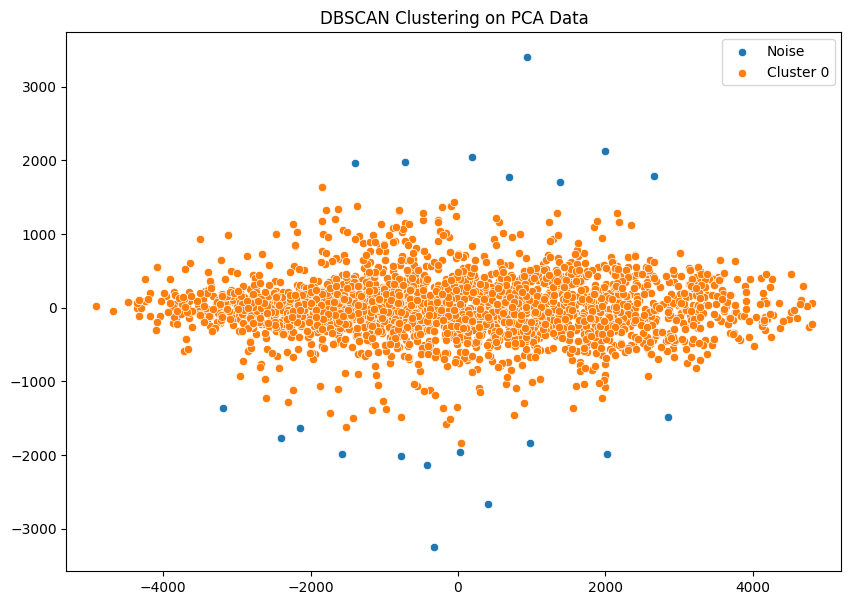

In [23]:
# Apply DBSCAN
epsilon = 400  # Radius of the neighborhood
min_samples = 5  # Minimum points required to form a cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(features_pca_clean)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.title('DBSCAN Clustering on PCA Data')
plt.axis('equal')

# Unique cluster labels
unique_clusters = np.unique(clusters)

# Plot each cluster
for cluster_label in unique_clusters:
    cluster_points = features_pca_clean[clusters == cluster_label]
    label = f'Cluster {cluster_label}' if cluster_label != -1 else 'Noise'
    sns.scatterplot(x=cluster_points[:, 0], y=cluster_points[:, 1], label=label)

# Add legend
plt.legend()
plt.show()

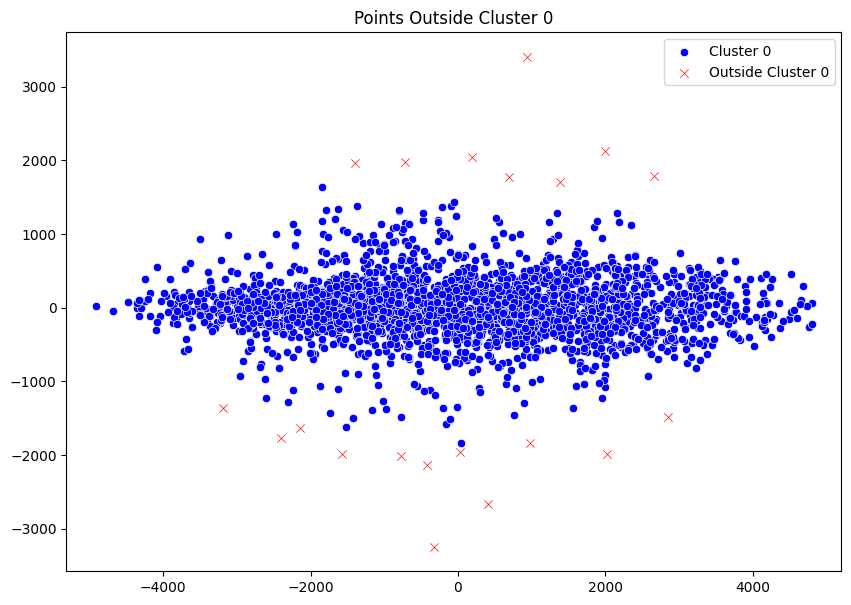

In [24]:
# Get indices of points outside of cluster 0
non_cluster_0_indices = np.where(clusters != 0)[0]

# Points outside of cluster 0
non_cluster_0_points = features_pca_clean[non_cluster_0_indices]

# Plot all points, highlighting those not in cluster 0
plt.figure(figsize=(10, 7))
plt.title('Points Outside Cluster 0')
plt.axis('equal')

# Plot points in cluster 0
sns.scatterplot(x=features_pca_clean[clusters == 0, 0], y=features_pca_clean[clusters == 0, 1], label='Cluster 0', color='blue')

# Plot points outside of cluster 0
sns.scatterplot(x=non_cluster_0_points[:, 0], y=non_cluster_0_points[:, 1], label='Outside Cluster 0', color='red', marker='x')

# Add legend
plt.legend()
plt.show()

In [25]:
len(non_cluster_0_indices)

20

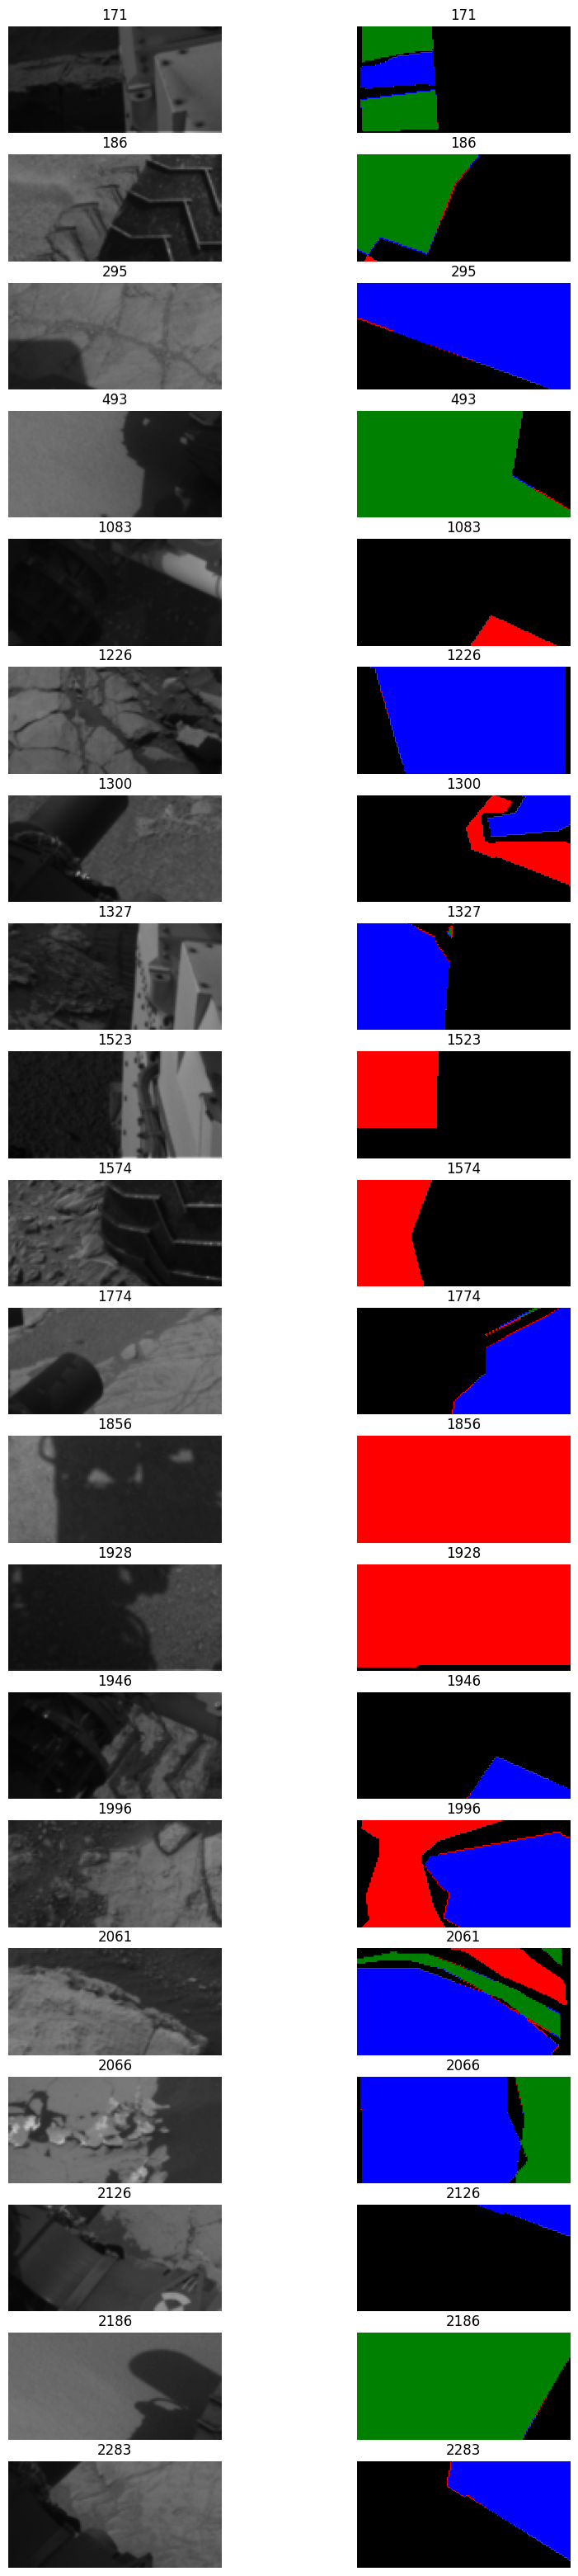

In [26]:
AugmentationHelper.plot_images_and_masks(input_images_clean[non_cluster_0_indices], output_masks_clean[non_cluster_0_indices], titles=non_cluster_0_indices, figsize=(10, 40))

These seem to be pictures where the robot's shadow or the robot itself got in the way, but among there are well classified samples

In [27]:
# keep only the clean samples from x and y
input_images_clean = np.delete(input_images_clean, non_cluster_0_indices, axis=0)
output_masks_clean = np.delete(output_masks_clean, non_cluster_0_indices, axis=0)

input_images_clean.shape, output_masks_clean.shape

((2363, 64, 128), (2363, 64, 128))

In [28]:
# Combine cleaned input images and masks into the same format as training_set
training_set_clean = np.stack((input_images_clean, output_masks_clean), axis=1)

# Save the cleaned data in the same format
output_path = "../data/ds_no_aliens_no95bg_no_outliers.npz"
np.savez(output_path, training_set=training_set_clean, test_set=test_set)


## Second round of DBSCAN

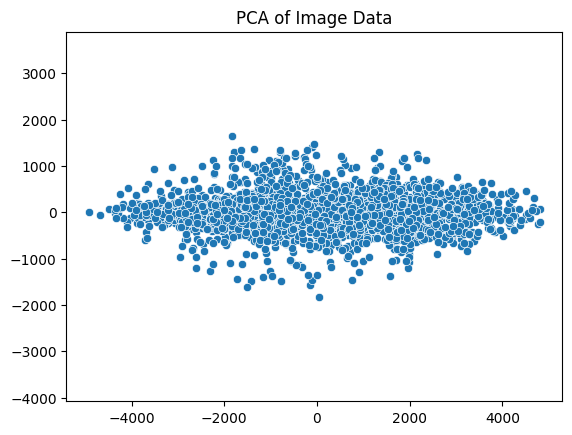

In [29]:
# Recompute PCA on the cleaned data
features_pca_clean = pca_distribution(input_images_clean)

All samples seem to be around the same distribution now, so we will not delete anymore